Megan White

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from imblearn.over_sampling import SMOTE
from transformers import BertModel, BertTokenizer
import torch

#Twitter & Reddit

In [2]:
#import data
twitter = pd.read_csv("Twitter_ Non-Advert-Tabelle 1.csv", sep=";",usecols=['text','label'])
reddit = pd.read_csv("Reddit_Combi.csv", sep=";",usecols=['body','label'])

reddit.rename(columns={'body': 'text'}, inplace=True)

df = pd.concat([twitter, reddit], ignore_index=True)

In [3]:
df

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1
3,Private health insurance delivers value for yo...,1
4,XpertOnline offers you the convenience of view...,1
...,...,...
5169,"Hi all, my mom has been working from home sinc...",1
5170,"I really think I lost my mind last night, I’d ...",1
5171,I feel like I died a long time ago and I just ...,1
5172,16f ... cant manage to make friends and get ov...,1


In [4]:
df.describe(include="all")

,text,label
count,5164,5174.000000
unique,5081,NaN
top,Less stress at hunyuan sanctuary,NaN
freq,4,NaN
mean,NaN,0.775609
std,NaN,0.417221
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [5]:
pd.isna(df).sum()

text     10
label     0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [8]:
def bert_encode(texts):
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

In [9]:
texts = df['text'].tolist()
embeddings = torch.stack([bert_encode(text) for text in texts]).numpy()

In [10]:
# Perform Synthetic Minority Oversampling TEchnique (SMOTE)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(embeddings, df['label'].values)

In [11]:
# Target Labels  After SMOTE
print('Positive Labels: ',len(y_res == 1))
print('Negative Labels: ',len(y_res== 0))

Positive Labels:  8012
Negative Labels:  8012


In [12]:
# Check dimension of the potential DTM
def dim():
    # Convert 'text' column to strings
    df['text'] = df['text'].astype(str)

    # Combine all texts into a single string, split into words, and convert to a set to count unique words
    dimensions = len(set(" ".join(df['text']).lower().split()))
    print(f'{dimensions} dimensions in the potential DFM.')

dim()


<ipython-input-12-23f70063cf7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)


34570 dimensions in the potential DFM.


In [13]:
# 20 most common words - frequency
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20] # This is a slice operation that selects the first 20 items [strat, end, step]
freq

I       25906
to      18041
and     16420
the     11718
a       10647
my       9690
of       8137
in       5919
that     5321
for      5313
me       4837
is       4697
have     4560
it       4334
but      4121
just     3994
with     3876
so       3425
this     3415
was      3324
Name: count, dtype: int64

In [14]:
# data cleaning -- lower casing
df['text']=df['text'].str.lower()
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq
dim()

<ipython-input-14-cf4aec08c880>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].str.lower()
<ipython-input-12-23f70063cf7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)


34570 dimensions in the potential DFM.


In [15]:
# data cleaning -- remove stop words (additional stop words)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

df['text']=df['text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq

# additional stop words (any additional words want to remove)
stop +=["i'm", "im"]
df['text']=df['text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop)) # lambda is that it allows you to define simple functions inline without the need for a separate def statement.
dim()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-15-443d50cd72d3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].apply(


34410 dimensions in the potential DFM.


<ipython-input-15-443d50cd72d3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].apply(
<ipython-input-12-23f70063cf7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)


In [16]:
# data cleaning -- remove punctations
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

<ipython-input-16-c4f4fca654e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [17]:
# data cleaning -- stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text']=df['text'].apply(
    lambda x: " ".join([st.stem(word) for word in x.split()])
)
dim()

15079 dimensions in the potential DFM.


<ipython-input-17-ad0620a9a550>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].apply(
<ipython-input-12-23f70063cf7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)


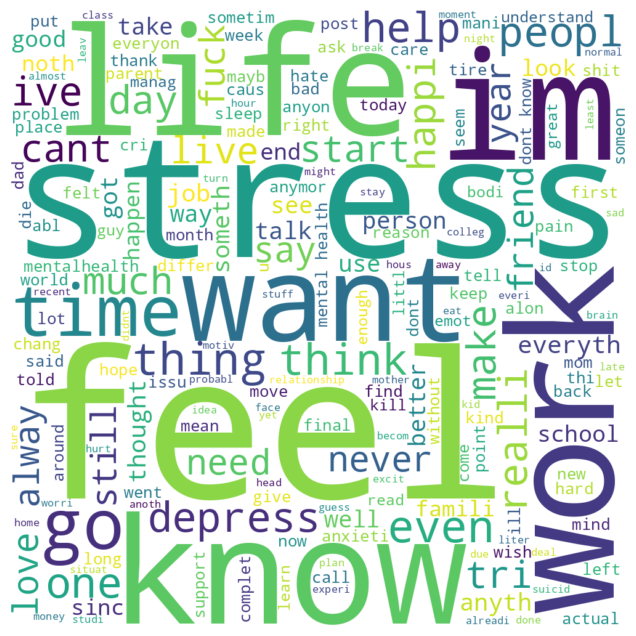

In [18]:
# word cloud
# ! pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Directly join the preprocessed text from the DataFrame
comment_words = ' '.join(df['text'])

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(background_color='white',
                      max_words=200,
                      width=1000,
                      height=1000).generate(comment_words)

# Display the generated word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

In [19]:
# build word dictionary and dtm
import gensim
from gensim import corpora

doc_complete = df['text']

corpus = [doc.split() for doc in doc_complete]

dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=2, no_above=0.75)

DFM = [dictionary.doc2bow(doc) for doc in corpus]

print("Total number of documents:", len(DFM))
print("Total number of unique tokens:", len(dictionary))

Total number of documents: 5164
Total number of unique tokens: 6852


In [20]:
# similarity
from gensim.similarities import MatrixSimilarity
simil = MatrixSimilarity(DFM,num_features=len(dictionary))
distance = 1-simil[DFM]

print(simil[DFM])
print(simil[DFM].shape)
len(simil[DFM])

[[0.9999999  0.07372098 0.08178608 ... 0.04170288 0.         0.03958263]
 [0.07372098 0.99999994 0.         ... 0.         0.         0.        ]
 [0.08178608 0.         1.         ... 0.         0.         0.07445808]
 ...
 [0.04170288 0.         0.         ... 1.0000002  0.05303301 0.15186527]
 [0.         0.         0.         ... 0.05303301 0.99999994 0.09228396]
 [0.03958263 0.         0.07445808 ... 0.15186527 0.09228396 0.9999999 ]]
(5164, 5164)


5164

In [21]:
# topic modeling
from gensim.models import LdaModel

n_topics = 4

ldamodel = gensim.models.LdaModel(DFM,
                           num_topics=n_topics,
                           id2word=dictionary,
                           random_state = 100,
                           passes=40)

# Print the top 10 terms for each of the 8 topics - optional
for topic_id in range(ldamodel.num_topics):
    print('Topic', topic_id)
    for term, probability in ldamodel.get_topic_terms(topic_id, topn=8):
        print('\t', ldamodel.id2word[term], probability)

Topic 0
	 stress 0.06457023
	 work 0.01888804
	 job 0.010868287
	 help 0.008075758
	 start 0.007476158
	 get 0.00691982
	 manag 0.005942314
	 take 0.0058939597
Topic 1
	 feel 0.027104482
	 im 0.021208804
	 get 0.020482615
	 like 0.018868206
	 ive 0.013427712
	 cant 0.012860805
	 it 0.012554458
	 dont 0.011957809
Topic 2
	 mentalhealth 0.028086258
	 health 0.02762019
	 stress 0.019657323
	 mental 0.012359115
	 mentalhealthmatt 0.009495706
	 inform 0.008780066
	 happi 0.0070528425
	 free 0.0065251524
Topic 3
	 want 0.012792643
	 like 0.012601786
	 life 0.011147753
	 peopl 0.010721441
	 me 0.009898432
	 one 0.009515783
	 feel 0.009102846
	 know 0.008980109


In [22]:
!pip install pyLDAvis

import pyLDAvis
pyLDAvis.enable_notebook()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.1 MB/s eta 0:00:00


In [23]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(ldamodel,
                                     DFM,
                                     dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.154704  0.079506       1        1  41.177982
1     -0.192910 -0.000183       2        1  38.068117
0      0.095505 -0.206014       3        1  12.074338
2      0.252108  0.126691       4        1   8.679562, topic_info=             Term         Freq        Total Category  logprob  loglift
19         stress  2652.000000  2652.000000  Default  30.0000  30.0000
573            im  2254.000000  2254.000000  Default  29.0000  29.0000
54         health   839.000000   839.000000  Default  28.0000  28.0000
14   mentalhealth   681.000000   681.000000  Default  27.0000  27.0000
51           work  1700.000000  1700.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
35            lot    91.720386   724.481281   Topic4  -5.5765   0.3775
6         depress    95.902423  1302.573696   Topic4  -5.5319  -0.1646
240          mind    86.375194   398.095610   Topic4  -5.6365   0.9162
79           well    84.389549   625.547629   Topic4  -5.6598   0.4410
242         point    82.794875   563.941597   Topic4  -5.6789   0.5256

[318 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
759       1  0.324475        3
759       2  0.327479        3
759       3  0.336492        3
759       4  0.009013        3
3083      1  0.979720  account
...     ...       ...      ...
554       2  0.638218     year
554       3  0.012880     year
554       4  0.006440     year
22        1  0.936159      you
22        4  0.062759      you

[515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' 

[12.80587215  8.58282351  5.54712937  4.90409568  4.61674973  4.48537975
  4.42191708  4.15281146  3.8498458   3.78714883]


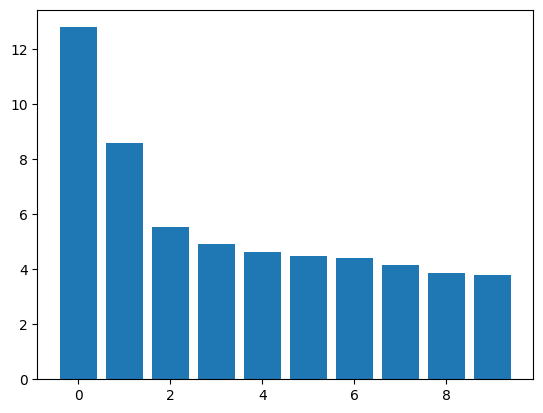

In [24]:
# SVD
from gensim import matutils
from gensim.models import LsiModel
from gensim.models import TfidfModel

tfidf = gensim.models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

# set n_SVD = 77 first

n_SVD=10
SVD_model = gensim.models.LsiModel(DFM_tfidf,
                            id2word=dictionary,
                            num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# singular values
singular_values = np.array(SVD_model.projection.s) # singular values
print(singular_values)

plt.bar(range(len(singular_values)), singular_values)
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()
svd_df = pd.DataFrame(svd_array)

In [25]:
# concatenates a Pandas DataFrame
model_df = pd.concat([df['label'], svd_df], axis=1)
model_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,0,1,2,3,4,5,6,7,8,9
0,1.0,0.040223,-0.010290,0.090694,0.009160,-0.009285,0.022194,0.031673,-0.038256,-0.042886,0.003383
1,1.0,0.008676,-0.003423,0.054067,-0.018843,-0.009572,0.032448,0.004626,-0.004228,0.007584,0.001999
2,1.0,0.079952,-0.028552,0.072656,0.092771,0.029599,-0.068051,-0.016762,0.008482,0.034841,0.004087
3,1.0,0.055172,-0.078171,0.158826,-0.107690,-0.041970,0.151997,0.030045,0.011586,0.015401,0.043397
4,1.0,0.029817,-0.005993,0.094789,-0.019460,-0.013927,0.050720,0.006098,0.008777,0.002527,0.002828
...,...,...,...,...,...,...,...,...,...,...,...
2898,NaN,0.304426,-0.023832,0.101292,0.077822,-0.031988,-0.090961,-0.059660,0.089091,0.030976,-0.004240
3768,NaN,0.246721,0.048137,-0.060880,-0.040718,-0.034533,-0.030525,0.049766,-0.077079,-0.005061,0.047907
3806,NaN,0.141057,0.027722,-0.016631,-0.037162,-0.049792,0.010107,0.081938,-0.058799,-0.066236,0.048608
3940,NaN,0.130273,0.023699,-0.000149,0.019332,0.000318,-0.016372,-0.035458,0.032327,0.044898,0.057307


In [27]:
pd.isna(model_df).sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


label    10
0        10
1        10
2        10
3        10
4        10
5        10
6        10
7        10
8        10
9        10
dtype: int64

In [28]:
model_df = model_df.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Decision Tree

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


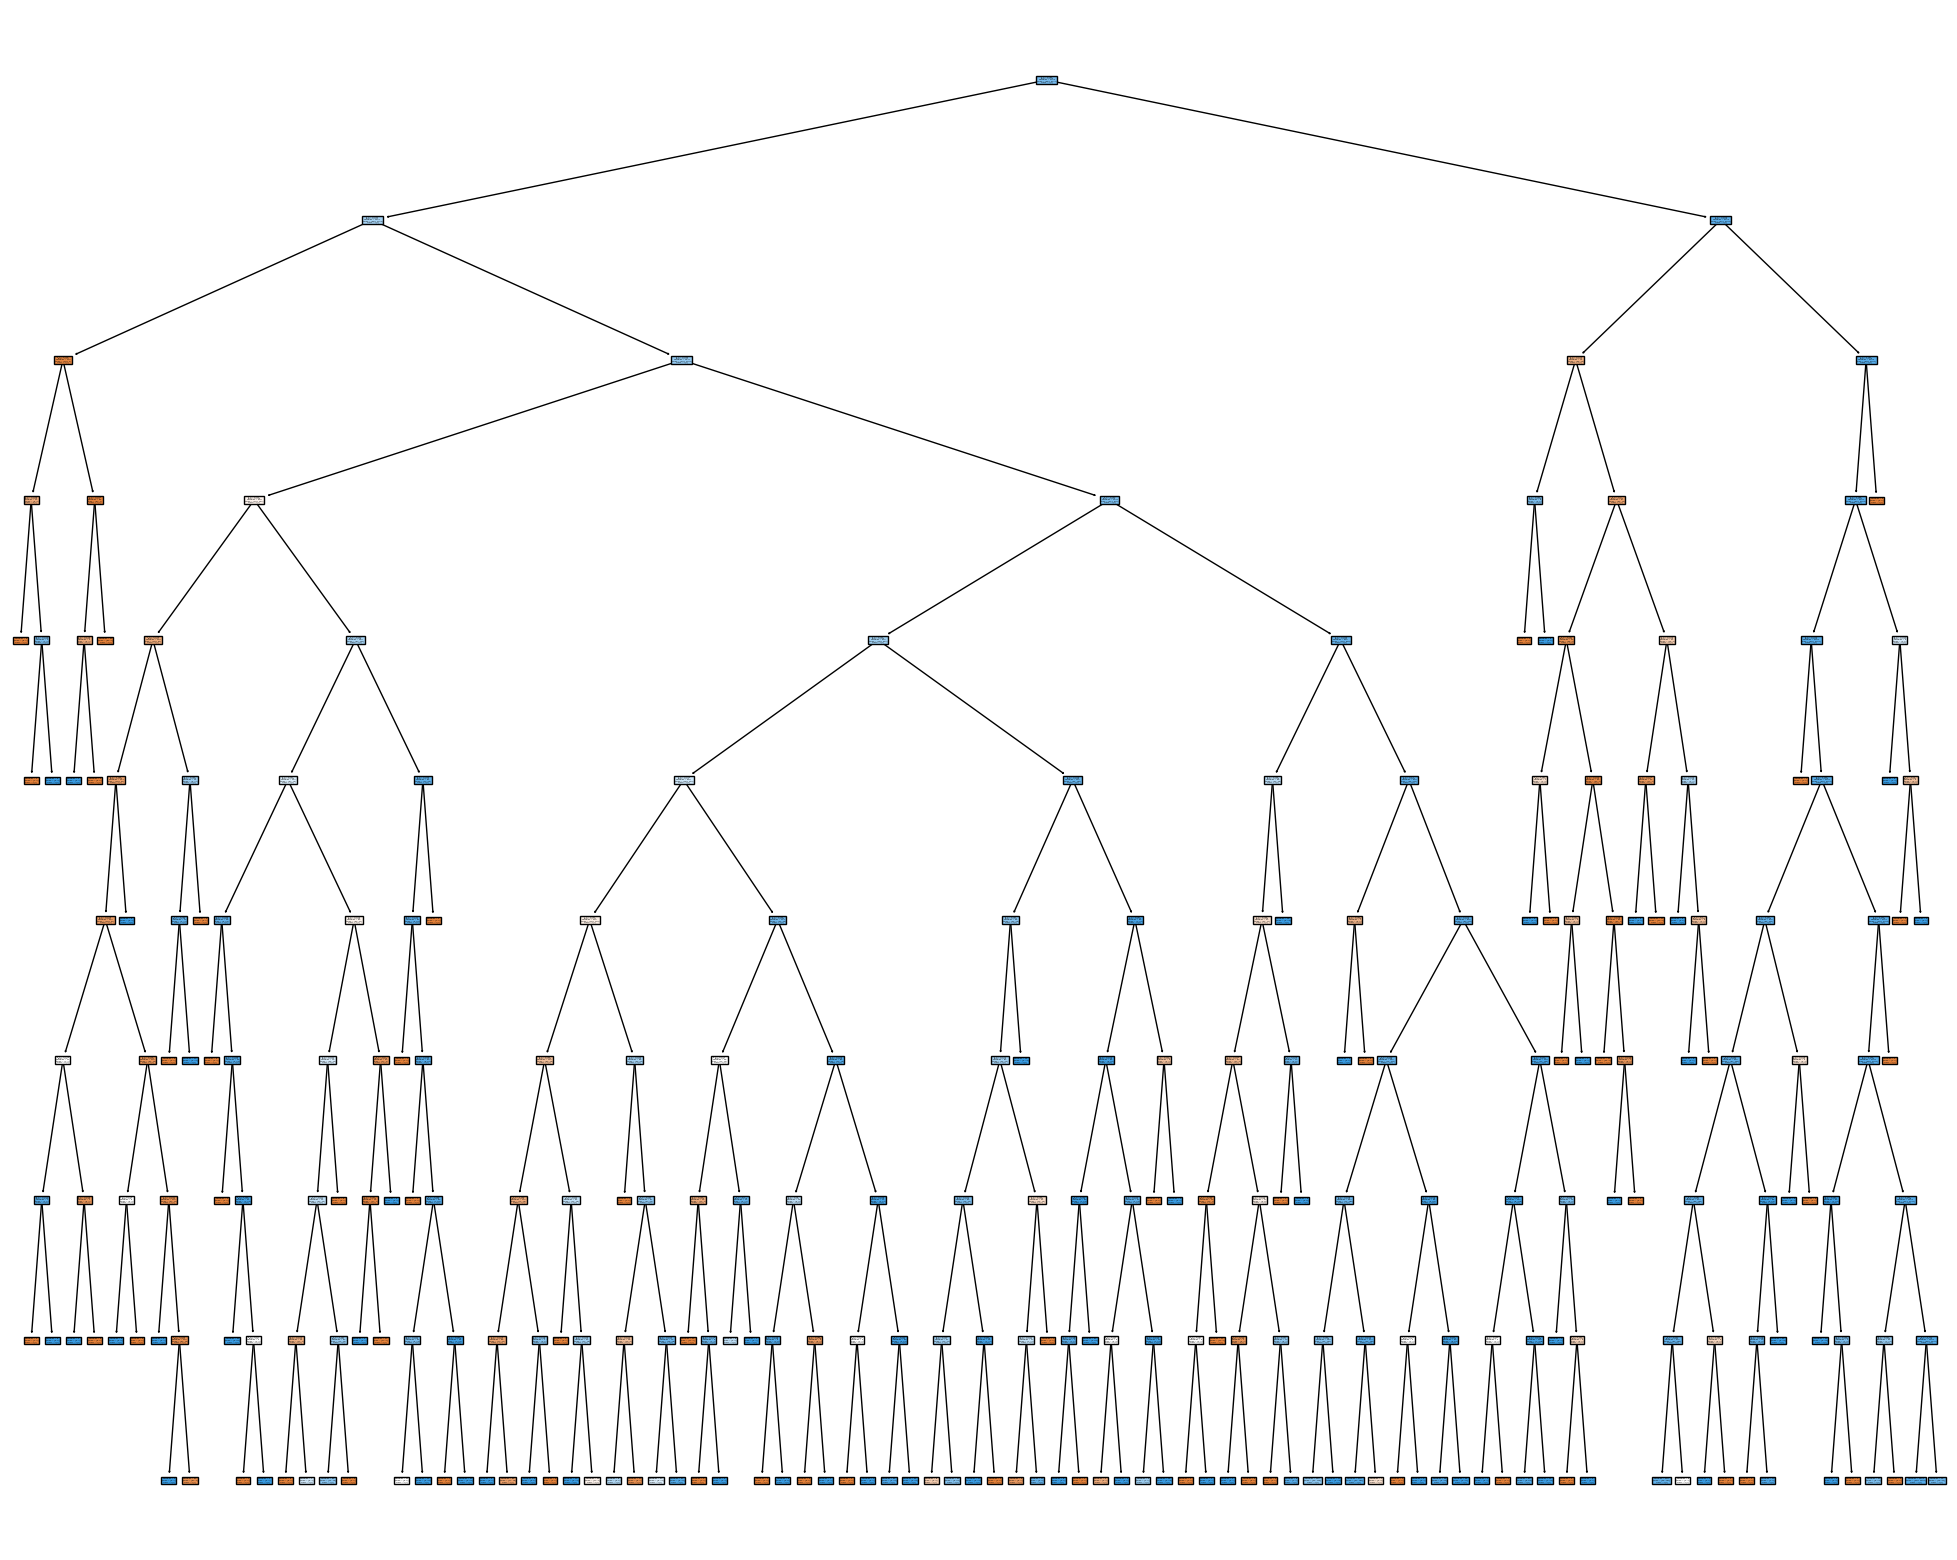

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

X = model_df.drop(columns=['label'])
y = model_df['label']

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train decision tree model
dt_model = DecisionTreeClassifier(random_state=0, max_depth = 10)
dt_model.fit(X_train, y_train)

# Predictions on validation set
y_pred = dt_model.predict(X_val)

plt.figure(figsize=[25,20])
tree.plot_tree(dt_model,
               feature_names=list(X_train.columns.values),
               class_names=True,
               filled=True) # paint nodes to indicate majority class for classification
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8234723569350145
0.700206696982224


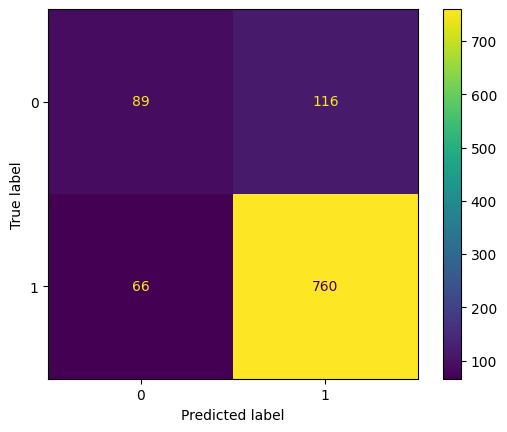

In [30]:
# model performance - confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score

# confusion matrix
cm = confusion_matrix(y_val,y_pred) # # row - true value; column - predicted
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# accuracy
print(dt_model.score(X_val,y_val))

# specificity
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn+fp)
# print(specificity)

# roc curve
prediction_prob = dt_model.predict_proba(X_val)
dt_auc = roc_auc_score(y_val, prediction_prob[:,1])
print(dt_auc)

Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0) # n_estimator = 100 (default); default=”sqrt”
rf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomForestClassifier(random_state=0)

In [32]:
rf.score(X_val,y_val)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8593598448108632

In [33]:
X.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5154, 10)

In [34]:
from sklearn.model_selection import GridSearchCV # parameter tuning
import numpy as np

param = {
    'n_estimators': [50,100], # number of trees
    'max_features': range(1,17) # number of mtrees
}

rf2 = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator=rf2,
                           param_grid=param, n_jobs=-1) # Number of jobs to run in parallel. -1 means using all processors
rfc = grid_search.fit(X_train,y_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'max_features': 1, 'n_estimators': 100}

In [36]:
# best score for the training set
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8374948514268901

In [37]:
grid_search.score(X_val,y_val)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8583899127061105

In [38]:
# variable importance

final_model = grid_search.best_estimator_

# feature importance
feature_imp = pd.Series(final_model.feature_importances_,
                        index=X.columns).sort_values(ascending=False) # One-dimensional ndarray with axis labels
feature_imp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6    0.114429
0    0.107586
1    0.106405
9    0.102517
7    0.102272
4    0.100860
2    0.096887
8    0.092408
5    0.088401
3    0.088235
dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


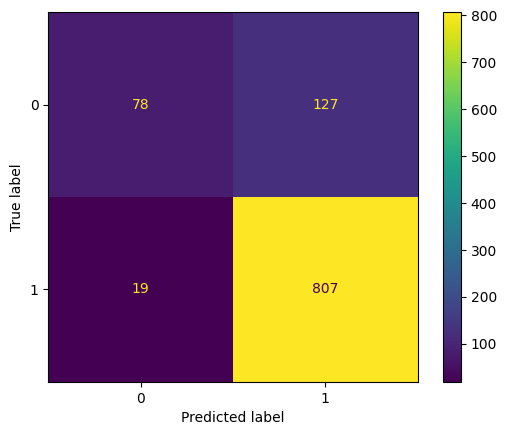

0.8583899127061105


In [39]:
prediction_prob =rfc.predict(X_val)

prediction =list(map(round,prediction_prob))  # map(fun, iter-iterable) =>
cm = confusion_matrix(y_val,prediction) # row - true value; column - predicted
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot() # disp.plot()
plt.show() # display all open figures

print(accuracy_score(y_val,prediction))